In [1]:
import os, dotenv

dotenv.load_dotenv()

os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["COMPOSIO_API_KEY"] = os.getenv("COMPOSIO_API_KEY")

In [3]:
## Models
from langchain_google_genai import  ChatGoogleGenerativeAI
from langchain_groq import  ChatGroq

gemini_model = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")
llama_model = ChatGroq(model="llama-3.3-70b-versatile")
deepseek_model = ChatGroq(model="deepseek-r1-distill-llama-70b")

In [4]:
from typing_extensions import TypedDict
from typing import Annotated, Literal

from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages

## State
class LinkedInGraphState(MessagesState):
    task: str
    critique: str
    post: str
    user_feedback: str
    llm_feedback: str
    context: list


In [5]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.types import Command, interrupt

tavily_tool = TavilySearchResults(max_results=5)

def web_search(state: LinkedInGraphState) -> Command[Literal["post_writer"]]:
    # results = tavily_tool.invoke(state['messages'])

    return Command(
        # state update
        update={"context": "results"},
        goto="post_writer"
    )

In [6]:
def post_writer(state: LinkedInGraphState)-> Command[Literal["post_analyzer"]]:
    
    return Command(
        update={"post": state['messages'][-1]},
        goto="post_analyzer"
    )

In [7]:
from pydantic import BaseModel, Field
from langchain_core.messages import SystemMessage, AIMessage, ToolMessage, HumanMessage, AnyMessage

class PostAnalystSchema(BaseModel):
    next_node: Literal["post_writer", "upload_post"]
    feedback: str = Field(description="The feedback about the post.")

post_analyst_llm = llama_model.with_structured_output(PostAnalystSchema)

ANALYST_PROMPT = """You are a LinkedIn post analyst. Your task is to route the given post to either back to the post_writer or to upload_post nodes. 
If the given post is well-written according to the given example posts, route it upload_post node, so that it can be posted on LinkedIn.
If the post does not match the style of given example posts, route it back to the post_writer node along with the feedback so that it can improve
the post.

## Example Posts:

#### Example 1:
Software engineers who do not speak well 

or do not dress presentable will struggle.

If your MO is I am great technical talent and thats all that matters. 

Neglect the effort to communicate better or make an impression to stakeholders.

When Ai catches up to become a principal engineer, your worth diminishes.

Get good at talking to people, care about how you present your ideas and yourself.

Will make such a difference.
Agree?
---

#### Example 2:
CS STUDENTS: Snapchat is paying entry-level engineers in nyc $190k.

Snap isn’t paying $190k to test their “ar googles.”

Snap is paying $190k or even $500k so you can be part of the team that can help them make their next $100Bn in market cap.

Too many “talent” and potentially even “motivated” young engineers get all “hip hip hooray” after landing the TC (offer letter)…

without visualizing the bigger picture. Why do you exist? What does your team and director do? Which team/product line makes the most money? How do you make the company better?

Someone can argue if the purpose of your specific role as an engineer is opaque and the intrigue to better your technical organization is missing…

there might be diminishing returns on hiring such an engineer in the advent of ai. 

Thoughts?
---

#### Example 3:
NYC Hacker house meetup. 

This was how it went down.

1/ gather at the hacker house
2/ eat and vibe
3/ go to the office 

7 headstarter residents and mentor(google) and hiring manager at startup ($145mn series A) came. 

I gave folks a game plan on how to get a job, roasted resumes and everyone just vibes.

IRL is where its at. 

Who agrees? 

Run it back again?
"""

def post_analyzer(state: LinkedInGraphState) -> Command[Literal["upload_post", "post_writer"]]:
    
    post_analysis = post_analyst_llm.invoke([SystemMessage(content=ANALYST_PROMPT)] + [state["post"]])

    user_feedback = ""
    if post_analysis.next_node == "post_writer":
        goto = "post_writer"
        user_feedback = interrupt("Please provide feedback about the post:")

    elif post_analysis.next_node == "upload_post":
        goto = "upload_post"

    return Command(
        update={"llm_feedback": post_analysis.feedback, 
                "user_feedback": user_feedback
               },
        goto=goto
    )

In [8]:
def upload_post(state: LinkedInGraphState) -> Command[Literal["__end__"]]:
    
    return Command(
        update={"messages": [HumanMessage(content="The post has successfully been posted!")]},
        goto="__end__"
    )
    

### Task Router

In [9]:
def task_router(state: LinkedInGraphState) -> Literal["post_writer", "web_search"]:
    if state.get("feedback"):
        return "post_writer"
    return "web_search"

## Graph

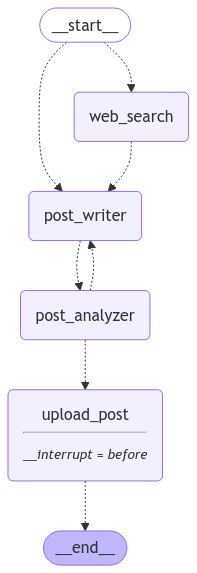

In [10]:
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

from typing import TypedDict, Annotated
from IPython.display import Image, display

# Build graph
builder = StateGraph(LinkedInGraphState)

builder.add_node("post_writer", post_writer)
builder.add_node("web_search", web_search)
builder.add_node("post_analyzer", post_analyzer)
builder.add_node("upload_post", upload_post)

builder.add_conditional_edges(START, task_router)

checkpointer = MemorySaver()
graph = builder.compile(checkpointer=checkpointer, interrupt_before=["upload_post"])

## Display graph
display(Image(graph.get_graph().draw_mermaid_png()))


In [11]:
config = {"configurable": {"thread_id": "abc"}}

for event in graph.stream({"messages": [HumanMessage(content="""
East vs west war is crazy. 
Deepseek was a fine tuned llama model. 

Only $6mn to train. 

For comparison Elons x.ai raised $6bn. 

Is dog shi***

And sam now raised $500bn for a weird US collab.

Will it be for surveillance as Oracle ceo said. 

Who knows? Thoughts?""")]}, config=config):
    print(event, end="\n\n")

{'web_search': {'context': 'results'}}

{'post_writer': {'post': HumanMessage(content='\nEast vs west war is crazy. \nDeepseek was a fine tuned llama model. \n\nOnly $6mn to train. \n\nFor comparison Elons x.ai raised $6bn. \n\nIs dog shi***\n\nAnd sam now raised $500bn for a weird US collab.\n\nWill it be for surveillance as Oracle ceo said. \n\nWho knows? Thoughts?', additional_kwargs={}, response_metadata={}, id='ee1993d3-74a3-49e3-ad1c-40409cc391d5')}}

{'post_analyzer': {'llm_feedback': 'The post seems to be well-structured and similar in style to the given example posts, with a clear and concise message and a call to action for thoughts and discussion.', 'user_feedback': ''}}

{'__interrupt__': ()}



In [12]:
graph.get_state(config).values

{'messages': [HumanMessage(content='\nEast vs west war is crazy. \nDeepseek was a fine tuned llama model. \n\nOnly $6mn to train. \n\nFor comparison Elons x.ai raised $6bn. \n\nIs dog shi***\n\nAnd sam now raised $500bn for a weird US collab.\n\nWill it be for surveillance as Oracle ceo said. \n\nWho knows? Thoughts?', additional_kwargs={}, response_metadata={}, id='ee1993d3-74a3-49e3-ad1c-40409cc391d5')],
 'post': HumanMessage(content='\nEast vs west war is crazy. \nDeepseek was a fine tuned llama model. \n\nOnly $6mn to train. \n\nFor comparison Elons x.ai raised $6bn. \n\nIs dog shi***\n\nAnd sam now raised $500bn for a weird US collab.\n\nWill it be for surveillance as Oracle ceo said. \n\nWho knows? Thoughts?', additional_kwargs={}, response_metadata={}, id='ee1993d3-74a3-49e3-ad1c-40409cc391d5'),
 'user_feedback': '',
 'llm_feedback': 'The post seems to be well-structured and similar in style to the given example posts, with a clear and concise message and a call to action for th

In [13]:
# Continue the graph execution
for event in graph.stream(
    Command(resume="The post should be well-written"), config
):
    print(event)
    print("\n")

{'upload_post': {'messages': [HumanMessage(content='The post has successfully been posted!', additional_kwargs={}, response_metadata={}, id='88819a48-bdac-4679-ba7a-b02ad2e41a00')]}}




----
## Second Graph (Enhanced Logic)

In [14]:
## State
class LinkedInGraphState(MessagesState):
    post: str
    user_feedback: str
    refined_post: str
    status: Literal["refining", "uploading", "completed"]


In [15]:
def post_writer(state: LinkedInGraphState) -> Command[Literal["web_search","style_refiner"]]:
    response = "invoking llm..."
    last_message = state["messages"][-1]

    if isinstance(last_message, AIMessage):
        if last_message.tool_calls:
            return Command(
                goto="web_search"
            )
    return Command(
        update={"post": response},
        goto="style_refiner"
    )

In [16]:
def style_refiner(state: LinkedInGraphState) -> Command[Literal["human_feedback"]]:
    
    return Command(
        update={"post": state["post"]},
        goto="human_feedback"
    )


In [17]:
def human_feedback(state: LinkedInGraphState) -> Command[Literal["upload_post", "style_refiner", "__end__"]]:
    review = interrupt({"post": state["post"], "is_approved": "Do you approve the post? [y/n]: "})

    if review.lower().strip() == "y":
        should_upload = interrupt("Should I upload the post? [y/n]: ")

        if should_upload.lower().strip() == "y":
            return Command(
                update={"status": "uploading"},
                goto="upload_post"
            )
        elif should_upload.lower().strip() == "n":
            return Command(
                update={
                    "messages": [HumanMessage(content="The post has been written!")],
                    "status": "completed"
                    },
                goto="__end__"
            )
    else:
        feedback = interrupt("Please provide feedback about the post: ")
        return Command(
            update={"user_feedback": feedback, "status": "refining"},
            goto="style_refiner"
        )

In [18]:
def upload_post(state: LinkedInGraphState) -> Command[Literal["__end__"]]:
    
    return Command(
        update={
            "messages": [HumanMessage(content="The post has successfully been posted!")],
            "status": "completed"
        },
        goto="__end__"
    )
    

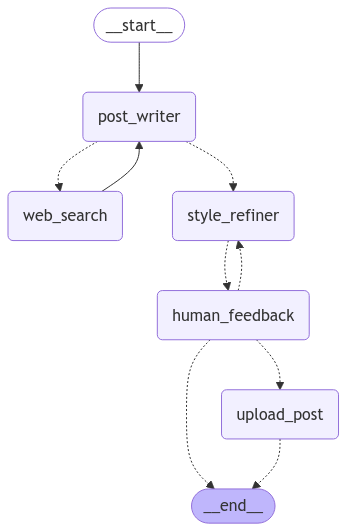

In [19]:
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

from typing import TypedDict, Annotated
from IPython.display import Image, display

# Build graph
builder = StateGraph(LinkedInGraphState)

builder.add_node("post_writer", post_writer)
builder.add_node("web_search", ToolNode([tavily_tool]))
builder.add_node("style_refiner", style_refiner)
builder.add_node("human_feedback", human_feedback)
builder.add_node("upload_post", upload_post)

builder.add_edge(START, "post_writer")
builder.add_edge("web_search", "post_writer")


checkpointer = MemorySaver()
graph = builder.compile(checkpointer=checkpointer)

## Display graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
config = {"configurable": {"thread_id": "123"}}

for event in graph.stream(
    {"messages": HumanMessage(content="Write a post about Qwen 2.5 Max")},
    config = config
):
    print(event)

{'post_writer': {'post': 'invoking llm...'}}
{'style_refiner': {'post': 'invoking llm...'}}
{'__interrupt__': (Interrupt(value={'post': 'invoking llm...', 'is_approved': 'Do you approve the post? [y/n]: '}, resumable=True, ns=['human_feedback:b68a112d-13ab-8470-6bae-38b9fae478c4'], when='during'),)}


In [21]:
for event in graph.stream(
    Command(resume="n"), config
):
    print(event)

{'__interrupt__': (Interrupt(value='Please provide feedback about the post: ', resumable=True, ns=['human_feedback:b68a112d-13ab-8470-6bae-38b9fae478c4'], when='during'),)}


In [22]:
for event in graph.stream(
    Command(resume="Use simple words"), config
):
    print(event)

{'human_feedback': {'user_feedback': 'Use simple words', 'status': 'refining'}}
{'style_refiner': {'post': 'invoking llm...'}}
{'__interrupt__': (Interrupt(value={'post': 'invoking llm...', 'is_approved': 'Do you approve the post? [y/n]: '}, resumable=True, ns=['human_feedback:97cf866e-6f82-61bf-0418-87c1e942a72f'], when='during'),)}


In [23]:
for event in graph.stream(
    Command(resume="y"), config
):
    print(event)

{'__interrupt__': (Interrupt(value='Should I upload the post? [y/n]: ', resumable=True, ns=['human_feedback:97cf866e-6f82-61bf-0418-87c1e942a72f'], when='during'),)}


In [24]:
for event in graph.stream(
    Command(resume="y"), config
):
    print(event)

{'human_feedback': {'status': 'uploading'}}
{'upload_post': {'messages': [HumanMessage(content='The post has successfully been posted!', additional_kwargs={}, response_metadata={}, id='f76ae1e3-c5bb-434c-b7e5-7401c710c296')], 'status': 'completed'}}


---
## Third Graph (More Autonomous)
<img src="../static/Linkedin_Agents_Team.png" alt="Graph" width="600">

In [83]:
from operator import add
## State
class LinkedInGraphState(MessagesState):
    posts: Annotated[list[str], add]
    human_feedback: str
    writer_task: str
    status: Literal["rewriting", "uploading", "deleting", "completed"]

In [71]:
class POST_WRITER(BaseModel):
    """The Post Writer Agent who writes a LinkedIn post."""
    task: str = Field(description="The complete details of the task given to the Post Writer Agent.")

In [88]:
linkedin_tools = []
tools_by_name = {tool.name: tool for tool in linkedin_tools}

In [89]:
main_linkedin_agent = llama_model.bind_tools([POST_WRITER] + linkedin_tools)

### Prompts

In [56]:
LINKEDIN_AGENT_PROMPT = """
You are a helpful LinkedIn Assistant.
"""

POST_WRITER_PROMPT = """
You are a LinkedIn post writer. Your job is to write/enhance a post to sound like me.

## Instructions
1. Post Style & Tone
    - When you are writing the post, make sure it matches the tone, clarity, and engagement level the given example posts.
    - You are given some example posts (within `<post>` tags) written by me. Take inspiration from the style and tone of them.
    - The post should not be too long.
2. Post Content
    - Do NOT make up the information, the post must be factually correct.
    - If you don't have enough information to write the post, use tool to gather information from internet.
    - Only add updated & correct information in the post.
3. Post Enhancement
    - If you are provided with a pre-written **post** and **feedback**, enhance the post based on the feedback.
    - Return the enhanced post.

---
Here are some example posts written by me:

<post>
Software engineers who do not speak well 

or do not dress presentable will struggle.

If your MO is I am great technical talent and thats all that matters. 

Neglect the effort to communicate better or make an impression to stakeholders.

When Ai catches up to become a principal engineer, your worth diminishes.

Get good at talking to people, care about how you present your ideas and yourself.

Will make such a difference.
Agree?
</post>

---
<post>
CS STUDENTS: Snapchat is paying entry-level engineers in nyc $190k.

Snap isn’t paying $190k to test their “ar googles.”

Snap is paying $190k or even $500k so you can be part of the team that can help them make their next $100Bn in market cap.

Too many “talent” and potentially even “motivated” young engineers get all “hip hip hooray” after landing the TC (offer letter)…

without visualizing the bigger picture. Why do you exist? What does your team and director do? Which team/product line makes the most money? How do you make the company better?

Someone can argue if the purpose of your specific role as an engineer is opaque and the intrigue to better your technical organization is missing…

there might be diminishing returns on hiring such an engineer in the advent of ai. 

Thoughts?
</post>
---
## Important Note
Just return the post, do NOT return any other text.
"""

In [99]:
def linkedin_agent(
    state: LinkedInGraphState,
) -> Command[Literal["action_executor", "__end__", "writer_agent"]]:
    # Calling the main LinkedIn Agent
    response = main_linkedin_agent.invoke(
        [SystemMessage(content=LINKEDIN_AGENT_PROMPT)] + state["messages"]
    )
    # Check for tool calls
    if hasattr(response, "tool_calls") and response.tool_calls:
        for call in response.tool_calls:
            tool_name = call.get("name")
            args = call.get("args")
            if tool_name == "POST_WRITER":
                # Route to Post Writer Agent
                return Command(
                    update={"writer_task": args["task"]}, goto="writer_agent"
                )
        # Route to Action Executor to Upload/Delete a post
        return "action_executor"
    # End of Conversation
    return "__end__"

In [100]:
from langgraph.prebuilt import create_react_agent

def post_writer(
    state: LinkedInGraphState
) -> Command[Literal["human_feedback_node"]]:

    human_feedback = state.get("human_feedback", None)
    task = state['writer_task']

    post_writer_agent = create_react_agent(
        llama_model,
        tools=[tavily_tool],
        prompt=POST_WRITER_PROMPT
        )
    # Check if human feedback is available
    if human_feedback:
        prompt = (
            "## Post \n\n{post}\n\n"
            "## Feedback \n\n{human_feedback}"
        )
        message = HumanMessage(content=prompt.format(post=state["posts"][-1], human_feedback=human_feedback))
    
    else:
        message = HumanMessage(content=task)  # task to write post

    # Invoke the writer agent
    response = post_writer_agent.invoke({"messages": [message]})
    post = response["messages"][-1].content
    # Go to Human Node to get feedback
    return Command(
        update={"posts": [post]},
        goto="human_feedback_node"
    )

In [101]:
def human_feedback(
    state: LinkedInGraphState,
) -> Command[Literal["linkedin_agent", "writer_agent"]]:

    post = state["posts"][-1]  # Most recent version of the post
    action = interrupt(
        {"post": post, "is_approved": "Do you approve the post? [y/n]: "}
    )

    # If user approves the post
    if action["is_approved"].lower().strip() == "y":
        last_message = state["messages"][-1]  # LinkedIn Agent tool call
        tool_messages = []

        for call in last_message.tool_calls:
            tool_name = call.get("name")
            tool_id = call.get("id")
            args = call.get("args")

            if tool_name == "POST_WRITER":
                tool_msg = ToolMessage(
                    name=tool_name,
                    tool_call_id=tool_id,
                    content="Task completed! Here is the post: \n\n" + state["posts"][-1],
                )
                tool_messages.append(tool_msg)

        # Route to Main LinkedIn Agent with tool message
        return Command(
                update={"messages": tool_messages},
                goto="linkedin_agent"
            )
    # If user doesn't approve the post
    elif action["is_approved"].lower().strip() == "n":
        feedback = interrupt("Please provide feedback about the post: ")
        # Route back to writer agent with feedback
        return Command(
            update={"human_feedback": feedback, "status": "rewriting"},
            goto="writer_agent",
        )

In [102]:
# def action_node(state: LinkedInGraphState) -> Command[Literal["linkedin_agent"]]:

#     result = []
#     for tool_call in state["messages"][-1].tool_calls:
#         tool_name = tool_call["name"]

#         if tool_name == "LINKEDIN_CREATE_LINKED_IN_POST":
#             action = interrupt({
#                 "post": tool_call["args"]["commentary"],
#                 "confirmation": "Should I upload the post? [y/n]: "
#             })
#             if action["confirmation"].lower().strip() == "y":
#                 tool = tools_by_name[tool_name]
#                 output = tool.invoke(tool_call["args"])
#                 result.append(
#                     ToolMessage(
#                         content=output, name=tool_name, tool_call_id=tool_call["id"]
#                     )
#                 )
#         elif tool_name == "LINKEDIN_DELETE_LINKED_IN_POST":
#             action = interrupt(
#                 {"confirmation": "Do you confirm the action of deleting the post? [y/n]: "}
#             )
#             if action["confirmation"].lower().strip() == "y":
#                 tool = tools_by_name[tool_name]
#                 output = tool.invoke(tool_call["args"])
#                 result.append(
#                     ToolMessage(
#                         content=output, name=tool_name, tool_call_id=tool_call["id"]
#                     )
#                 )
#         elif tool_name == "LINKEDIN_GET_MY_INFO":
#             tool = tools_by_name[tool_name]
#             output = tool.invoke(tool_call["args"])
#             result.append(
#                 ToolMessage(
#                     content=output, name=tool_name, tool_call_id=tool_call["id"]
#                 )
#             )
#     # Route to Main LinkedIn Agent
#     return Command(
#             update={"messages": result},
#             goto="linkedin_agent"
#         )

In [103]:
def action_node(state: LinkedInGraphState) -> Command[Literal["linkedin_agent"]]:
    
    def execute_tool(tool_call):
        """Executes the given tool call and returns a ToolMessage."""
        tool = tools_by_name[tool_call["name"]]
        output = tool.invoke(tool_call["args"])
        return ToolMessage(content=output, name=tool_call["name"], tool_call_id=tool_call["id"])
    
    result = []
    ## Confirmation messages for tools
    confirmation_messages = {
        "LINKEDIN_CREATE_LINKED_IN_POST": {
            "post": lambda args: args["commentary"],
            "confirmation": "Should I upload the post? [y/n]: "
        },
        "LINKEDIN_DELETE_LINKED_IN_POST": {
            "confirmation": "Do you confirm the action of deleting the post? [y/n]: "
        }
    }
    
    for tool_call in state["messages"][-1].tool_calls:
        tool_name = tool_call["name"]
        
        if tool_name in confirmation_messages:
            confirmation_data = confirmation_messages[tool_name]
            prompt_data = {"confirmation": confirmation_data["confirmation"]}
            if "post" in confirmation_data:
                prompt_data["post"] = confirmation_data["post"](tool_call["args"])
            
            action = interrupt(prompt_data)
            if action["confirmation"].lower().strip() == "y":
                result.append(execute_tool(tool_call))
        else:
            result.append(execute_tool(tool_call))
    
    return Command(update={"messages": result}, goto="linkedin_agent")


In [107]:
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

from typing import TypedDict, Annotated
from IPython.display import Image, display

# Build graph
builder = StateGraph(LinkedInGraphState)

builder.add_node("linkedin_agent", linkedin_agent)
builder.add_node("writer_agent", post_writer)
builder.add_node("human_feedback_node", human_feedback)
builder.add_node("action_executor", action_node)

builder.add_edge(START, "linkedin_agent")

## Checkpointer
checkpointer = MemorySaver()
graph = builder.compile(checkpointer=checkpointer)


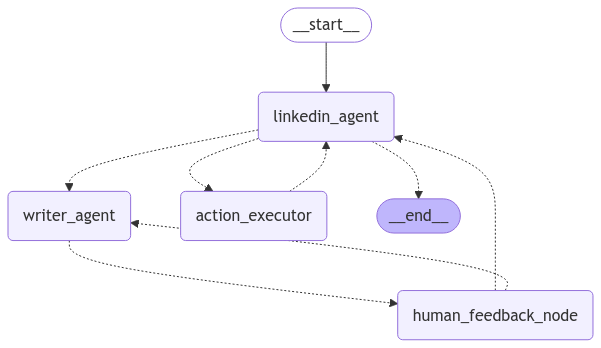

In [113]:
## Display graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))